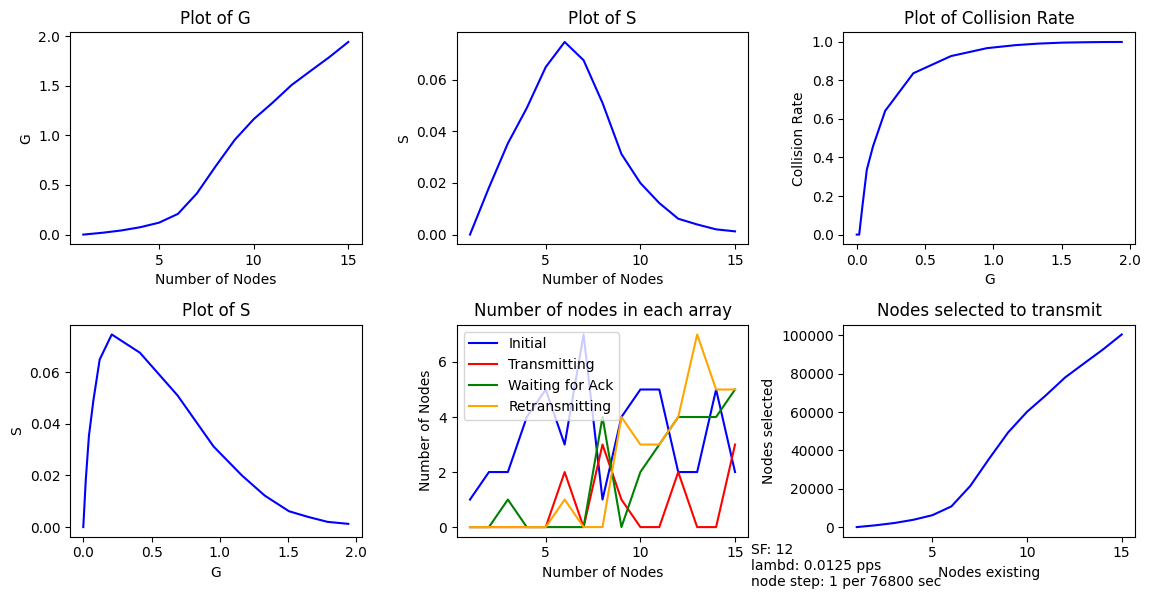

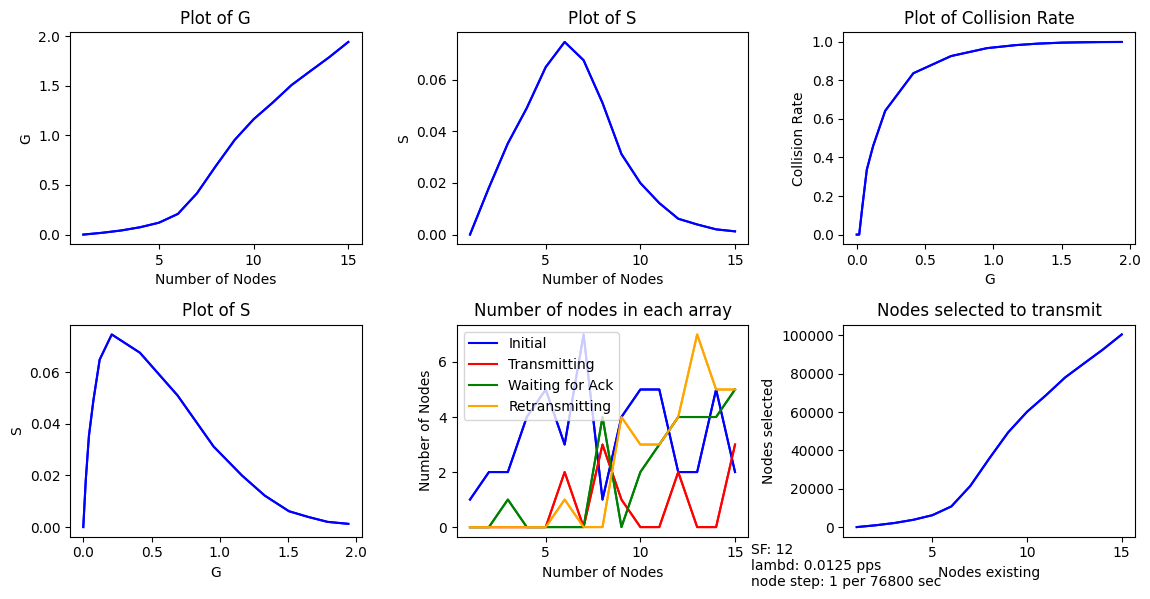

Total_successful_transmissions: 22647
Total_collisions: 593334
Total_num_to_transmit: 615981

node_num = 15


Text(0.63, 0.015, 'SF: 12\nlambd: 0.0125 pps\nnode step: 1 per 76800 sec \nsim duration: 319.15338194444445mins')

In [1]:
from IPython.display import display, clear_output
from Node_Class import Node
from Gateway_Class import Gateway
import Time_on_Air_Calculator as ToA_calc
from Tx_mode_functions import select_nodes_to_transmit, check_collisions, check_uplink_finished
from Rx_mode_functions import check_transmission_success
import matplotlib.pyplot as plt
import numpy as np
import math

plt.ion()

BW = 125000    # Bandwidth in Hz
SF = 12        # Spreading Factor
preamble = 8   # length of preamble in bytes
payload = 25   # payload in bytes
header = 0     # Header: if enabled --> 0 |  if disabled --> 1
CRC = 1        # if enabled --> 1 | if disabled --> 0 | We enable this only during the uplink slot for error detection 
DE = 1         # when LowDataRateOptimize = 1 -->1 | otherwise --> 0
CR = 1         # Coding Rate: 4/5 --> 1 | 4/6 --> 2 | 4/7 --> 3 | 4/8 --> 4

ToA = round(ToA_calc.Time_on_Air(BW, SF, preamble, payload, header, CRC, DE, CR))  # Find the Time on Air based on the parameters
T_payload = round(ToA_calc.find_payload_no_error_bits(BW, SF, payload, header, CRC, DE, CR))
ack_duration = round(ToA_calc.find_ack_duration(BW, SF, preamble))                                                                 # Duration of Gateway's acknowledgement transmission(530msec)
RX_delay1 = 1000                                                            # Duration of RX1 delay                                             # Total time of a node's transmission including the RX delay and the acknowledgment
min_timeout_for_ack = 1000
max_timeout_for_ack = 3000                                                   # Maximum time waiting for acknowledgment to be received
T_retransmission = 8700

time = 0                                                                    # Represents the time passed from the beggining of the simulation in msecs. Changes in the end of every cycle
node_num = 0                                                                # Holds the number of total nodes in the system. It increases based on the node_counter.
node_counter = 0                                                            # Counts cycles until the increasing of each node 
sim_duration =7200000                                                       # Simulation duration in msecs
lambd = 1/80000
# node_step = 25600000 * 3
node_step = 25600000 * 3
k = node_step

node_list = []                                                              #Holds the nodes that initiate new transmissions                                                      #Holds the nodes that chose to transmit, or retransmit
nodes_to_retransmit = []                                                    #Holds the nodes that will retransmit at a random moment of time
nodes_transmitting = []                                                     #Holds the node currently transmitting                                                       #Stores the collisions that occur in each cycle
waiting_for_ack = []                                                        #Holds the nodes that are in the waiting_for_ack state    

S = []                                                                       #The throughput of the channel                                                                 #Holds the throughput of the channel for a single cycle
G = []                                                                       #The total traffic load of the channel                                                                 #Holds the total traffic load of the channel for each cycle
collision_rate = []
#---------------------------------------------------------------------------------------------------------------------------------------------
nodes_selected = []
len_node_list = []
len_nodes_transmitting = []
len_waiting_for_ack = []
len_nodes_to_retransmit = []
nodes_for_plots = []
#---------------------------------------------------------------------------------------------------------------------------------------------
S = []                                                                       #The throughput of the channel                                                                 #Holds the throughput of the channel for a single cycle
G = []                                                                       #The total traffic load of the channel                                                                 #Holds the total traffic load of the channel for each cycle
collision_rate = []
num_to_transmit = 0
successful_transmissions = 0                                                                  #Holds the collision probabillity for each cycle.
total_successful_transmissions = 0
total_num_to_transmit = 0
collisions = 0
total_collisions = 0

gateway = Gateway(ack_duration)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
node_axis = np.linspace(1, node_num, len(S))

ax1.set(xlabel='Number of Nodes', ylabel='G', title='Plot of G')
ax2.set(xlabel='Number of Nodes', ylabel='S', title='Plot of S')
ax3.set(xlabel='G', ylabel='Collision Rate', title='Plot of Collision Rate')
ax4.set(xlabel='G', ylabel='S', title='Plot of S')
ax5.set(xlabel='Number of Nodes', ylabel='Number of Nodes', title='Number of nodes in each array')
ax6.set(xlabel='Nodes existing', ylabel='Nodes selected', title='Nodes selected to transmit')

# Initialize line objects
line_G, = ax1.plot([], [], color='blue')
line_S, = ax2.plot([], [], color='blue')
line_collision_rate, = ax3.plot([], [], color='blue')
line_S_vs_G, = ax4.plot([], [], color='blue')
line_node_list, = ax5.plot([], [], label='Initial', color='blue')
line_nodes_transmitting, = ax5.plot([], [], label='Transmitting', color='red')
line_waiting_for_ack, = ax5.plot([], [], label='Waiting for Ack', color='green')
line_nodes_to_retransmit, = ax5.plot([], [], label='Retransmitting', color='orange')
line_nodes_selected, = ax6.plot([], [], color='blue')

ax5.legend()

plt.tight_layout()
plt.subplots_adjust(right=0.95)
fig.text(0.63, 0.015, f'SF: {SF}\nlambd: {round(lambd*1000, 4)} pps\nnode step: 1 per {round(node_step/1000)} sec', fontsize=10, color='black')  # Adjust the position (3, 0.5) and other parameters as needed



while(num_to_transmit * ToA/node_step <= 2):
    if(node_num < 1000):
        if(time%node_step == 1):                                           #increase the number of nodes every 20 msec until node number is equal to 1000.
            node_num += 1                       
            node_list.append(Node(node_num, ToA))

    num_to_transmit += select_nodes_to_transmit(time, node_list, nodes_transmitting, nodes_to_retransmit, lambd)

    check_collisions(nodes_transmitting, gateway, ack_duration)

    check_uplink_finished(time, nodes_transmitting, RX_delay1, min_timeout_for_ack, max_timeout_for_ack, waiting_for_ack)

    results_by_cycle = check_transmission_success(time, gateway, waiting_for_ack, node_list, nodes_to_retransmit, ToA, T_retransmission, ack_duration)
    
    if(results_by_cycle == 1):
        successful_transmissions += 1
        gateway.successful_acks +=1 
    elif(results_by_cycle == -1):
        collisions +=1

    if(time%node_step == 1):
        collided_acks = gateway.ack_attempts - gateway.successful_acks
        num_to_transmit = collisions + successful_transmissions
        nodes_selected.append(num_to_transmit)
        
        # G.append((num_to_transmit * ToA + gateway.ack_attempts * ack_duration)/node_step)
        G.append(num_to_transmit * ToA/node_step)
        # S.append((T_payload * successful_transmissions + ack_duration * gateway.successful_acks)/node_step)
        S.append(ToA * successful_transmissions/node_step)

        if(total_num_to_transmit > 0):
            # collision_rate.append((collisions + collided_acks)/(num_to_transmit + gateway.ack_attempts))
            collision_rate.append(collisions/num_to_transmit)

        else:
            collision_rate.append(0)

        len_node_list.append(len(node_list))
        len_nodes_transmitting.append(len(nodes_transmitting))
        len_waiting_for_ack.append(len(waiting_for_ack))
        len_nodes_to_retransmit.append(len(nodes_to_retransmit))

        clear_output(wait=True)

        node_axis = np.linspace(1, node_num, len(S))

        # Update line data
        line_G.set_data(node_axis, G)
        line_S.set_data(node_axis, S)
        line_collision_rate.set_data(G, collision_rate)
        line_S_vs_G.set_data(G, S)
        line_node_list.set_data(node_axis, len_node_list)
        line_nodes_transmitting.set_data(node_axis, len_nodes_transmitting)
        line_waiting_for_ack.set_data(node_axis, len_waiting_for_ack)
        line_nodes_to_retransmit.set_data(node_axis, len_nodes_to_retransmit)
        line_nodes_selected.set_data(node_axis, nodes_selected)
        
        # Adjust axes limits
        for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
            ax.relim()
            ax.autoscale_view()


        plt.tight_layout()
        plt.subplots_adjust(right=0.95)
        display(fig)
        
        total_successful_transmissions += successful_transmissions
        total_collisions += collisions
        total_num_to_transmit += num_to_transmit
        num_to_transmit = 0
        successful_transmissions = 0
        collisions = 0
        gateway.ack_attempts = 0
        gateway.successful_acks = 0
    
    time += 1
plt.ioff()

ax1.plot(node_axis, G, label='G', color = 'blue')
# ax1.scatter(node_axis, G, label='G', color = 'blue')
ax2.plot(node_axis, S, label='S', color = 'blue')
# ax2.scatter(node_axis, S, label='S', color = 'blue')
ax3.plot(G, collision_rate, label='Collision Rate', color = 'blue')
# ax3.scatter(G, collision_rate, label='Collision Rate', color = 'blue')
ax4.plot(G, S, label='S', color = 'blue')
# ax4.scatter(G, S, label='S', color = 'blue')
ax5.plot(node_axis, len_node_list, label='node_list length', color = 'blue')
ax5.plot(node_axis, len_nodes_transmitting, label='nodes_transmitting length', color = 'red')
ax5.plot(node_axis, len_waiting_for_ack, label='waiting_for_ack length', color = 'green')
ax5.plot(node_axis, len_nodes_to_retransmit, label='nodes_to_retransmit length', color = 'orange')
ax6.plot(node_axis, nodes_selected, label='Nodes_selected to Transmit', color = 'blue')
# ax6.scatter(node_axis, nodes_selected, label='Nodes_selected to Transmit', color = 'blue')


plt.show()
print(f'Total_successful_transmissions: {total_successful_transmissions}')
print(f'Total_collisions: {total_collisions}')
print(f'Total_num_to_transmit: {total_num_to_transmit}')
print(f'\nnode_num = {node_num}')

fig.text(0.63, 0.015, f'SF: {SF}\nlambd: {round(lambd*1000, 4)} pps\nnode step: 1 per {round(node_step/1000)} sec \nsim duration: {time/3600000}mins', fontsize=10, color='black')  # Adjust the position (3, 0.5) and other parameters as needed